In [8]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)
print(sys.path)

import time

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from itertools import product
import torch
import torch.distributions as dist
torch.manual_seed(0)

from lib.neural_network import ShallowExp
from lib.PDE import KdV
from lib.measure import MetropolisHastingsSampler
#from lib.PDEmerge import Problem, ParameterNN, estimF, estimM, targetDistribution, gradNN

['/home/ggarnier/research/inverse-neural-galerkin/inverse-neural-galerkin/src/notebooks', '/home/ggarnier/anaconda3/envs/inverse-neural-galerkin/lib/python311.zip', '/home/ggarnier/anaconda3/envs/inverse-neural-galerkin/lib/python3.11', '/home/ggarnier/anaconda3/envs/inverse-neural-galerkin/lib/python3.11/lib-dynload', '', '/home/ggarnier/anaconda3/envs/inverse-neural-galerkin/lib/python3.11/site-packages', '/home/ggarnier/research/inverse-neural-galerkin/inverse-neural-galerkin/src', '/home/ggarnier/research/inverse-neural-galerkin/inverse-neural-galerkin', '/home/ggarnier/research/inverse-neural-galerkin/inverse-neural-galerkin', '/home/ggarnier/research/inverse-neural-galerkin/inverse-neural-galerkin', '/home/ggarnier/research/inverse-neural-galerkin/inverse-neural-galerkin', '/home/ggarnier/research/inverse-neural-galerkin/inverse-neural-galerkin']


ModuleNotFoundError: No module named 'ode'

In [5]:
torch.__version__

'2.0.1'

# Merge PDE & NN

In [4]:
class Problem:
    def __init__(self, name, initial_condition):
        self.name = name
        self.initial_condition = initial_condition
    def evaluate(self, t, x, f):
        if name=='KdV':
            KDV=KdV(initial_condition)
        else:
            raise Exception("The problem name has not been found in the database")

class ParameterNN:
    """
    Code a class to define a Parameter theta. 
    """
    
    def __init__(self, w, b, c):
        self.w = w
        self.b = b
        self.c = c
      
    
def kdv(xspace, model):
    funct=torch.zeros(len(xspace))
    iter = 0
    for x in xspace:
        x = x.unsqueeze(1)
        x.requires_grad = True
        u = model(x)

        u_x = torch.autograd.grad(u,x, retain_graph=True, create_graph=True)
        u_xx = torch.autograd.grad(u_x[0],x, retain_graph=True, create_graph=True)
        u_xxx = torch.autograd.grad(u_xx[0],x)
        aux = - u_xxx[0] + 6 * u_x[0] * u.unsqueeze(1)
        funct[iter] = aux[0]
        iter = iter + 1
    return funct

class estimF:
    """
    Compute the Integral F by the Monte Carlo methods
    """
    def __init__(self, d, m, NN, f, samples):
        self.NN = NN
        self.f = f
        self.samples = samples
        self.d = d
        self.m = m

    def __call__(self, t, theta):
        self.NN = ShallowExp(self.d, self.m, theta)
        # Compute every U(theta, xi) and return tensor([[value1 at x1], [value2 at x2], ...])
        y_pred = self.NN(self.samples)
        
        # Compute every gradU(theta,xi)
        gradU = gradNN(self.NN)
        result_grad = torch.zeros(self.samples.size()[0], 2 * m + d * m)
        result_grad= gradU.return_grad(self.samples)
        
        result_f = self.f(self.samples, self.NN)
        result_f = result_f.unsqueeze(1)  
    
        return torch.mean(result_grad * result_f, dim=0)
    
class estimM:
    """
    Compute the Integral M by the Monte Carlo methods
    """
    def __init__(self, d, m, samples):
        self.samples = samples
        self.d = d
        self.m = m

    def __call__(self, theta):
        NN = ShallowExp(self.d, self.m, theta)
        
        # Compute every U(theta, xi) and return tensor([[value1 at x1], [value2 at x2], ...])
        y_pred = NN(self.samples)
        
        # Compute every gradU(theta,xi)
        gradU = gradNN(NN)
        result_grad = torch.zeros(self.samples.size()[0], 2 * m + d * m)
        result_grad= gradU.return_grad(self.samples)
        
        tensorproduct = torch.zeros(self.samples.size()[0], 2 * m + d * m, 2 * m + d * m)
        for iter in range(0, self.samples.size()[0]):
            tensorproduct[iter] = torch.outer(result_grad[iter], result_grad[iter])    
         
        return torch.mean(tensorproduct, dim=0)
    
class targetDistribution:
    """
    Define the distribution we use to make our integration. 
    """
    def __init__(self, NN):
        self.NN = NN
    def value(self, x):
        return self.NN(x)
    
# class gradNN:
#     def __init__(self, NN):
#         self.NN = NN
#     def return_grad(self, x):        
#         y_pred = self.NN(x)
#         d = self.NN.d
#         m = self.NN.m
#         result_grad = torch.zeros(y_pred.size()[0], 2 * m + d * m)
#         for iter in range(y_pred.size()[0]):
#             grad_theta = torch.autograd.grad(y_pred[iter], (self.NN.theta), retain_graph=True)
#             result_grad[iter] = grad_theta[0]
#         return result_grad
    
class gradNN:
    def __init__(self, NN):
        self.NN = NN
    def return_grad(self, x):        
        y_pred = self.NN(x)
        print('TEST', y_pred.size())

        d = self.NN.d
        m = self.NN.m
        result_grad = torch.zeros(y_pred.size()[0], 2 * m + d * m)

        def myfunct(x):
            return torch.autograd.grad(x, (self.NN.theta), retain_graph=True)
        for iter in range(y_pred.size()[0]):
            grad_theta = myfunct(y_pred[iter])
            result_grad[iter] = grad_theta[0]
        cms = list(map(myfunct, y_pred))
        print(cms)
        
        raise ValueError('A very specific bad thing happened.')
        return result_grad
        

In [5]:
# Parameters of the input
d= 1 # spatial dimension
m = 10 # Number of coefficients in the expansion

start = time.time()

# Number of sample to generate
num_samples = 1000
# Initial state of the Markov chain
initial_state = torch.zeros(d)
    # Target distribution : normal_law
def target_distribution(x):
    """Target distribution: a standard Gaussian."""
    return torch.exp(-0.5 * x**2) / torch.sqrt(2 * torch.tensor(3.141592653589793))

    # Proposal distribution: a normal law with mean x and standard deviation 'sigma'
def proposal_distribution(x):
    """Proposal distribution: a Gaussian with mean x and standard deviation sigma."""
    sigma = 0.5
    return dist.Normal(x, sigma)

    # Create the sampler instance
NN = ShallowExp(d, m)
target_distribution = targetDistribution(NN)
sampler = MetropolisHastingsSampler(num_samples, initial_state, target_distribution.value, proposal_distribution)
    # Run Metropolis-Hastings algorithm
samples, acceptance_rate = sampler.metropolis_hastings()
samples = torch.rand(num_samples, 1)*30-10
#print(samples)

# Contruct estimF
theta = torch.rand(2 * m + d * m) * 1

Mapprox = estimM(d, m, samples)
print(theta)
M = Mapprox(theta)
print('M ', M)

Fapprox = estimF(d, m, NN, kdv, samples)
F = Fapprox(1, theta)
print('F', F)

end = time.time()
print('Code executed in', end - start, 'secondes')

/home/ggarnier/Documents/project/inverse-neural-galerkin/src/lib/neural_network.py:9: UserWarning: The neural network has been initiated with random theta
  warnings.warn("The neural network has been initiated with random theta")


tensor([0.5169, 0.3770, 0.2345, 0.0444, 0.9183, 0.1964, 0.5672, 0.9005, 0.4370,
        0.1723, 0.0163, 0.5831, 0.2491, 0.5365, 0.6597, 0.3583, 0.8390, 0.4349,
        0.3005, 0.1694, 0.6517, 0.1909, 0.6051, 0.4369, 0.8436, 0.2549, 0.2537,
        0.4354, 0.1946, 0.6906])
TEST torch.Size([1000])


ValueError: A very specific bad thing happened.

In [6]:
a = torch.tensor([0.6322])
a.unsqueeze(0)

tensor([[0.6322]])

# MERGE

### Define the Initial Condition $u_0$

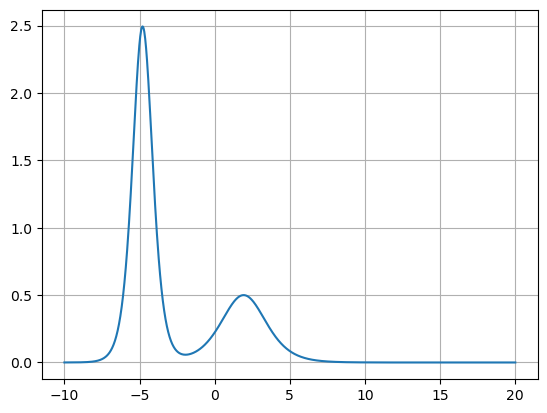

In [7]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

def exactKdVTwoSol(x, t):
    '''
    Same setup as in https://doi.org/10.1016/0021-9991(84)90004-4

    Analytical and numerical aspects of certain nonlinear evolution equations. III. Numerical, Korteweg-de Vries equation
    Thiab R Taha, Mark I Ablowitz
    Journal of Computational Physics, Volume 55, Issue 2, August 1984, Pages 231-253
    '''

    k = jnp.asarray([1., jnp.sqrt(5.)])
    eta = jnp.asarray([0., 10.73])
    t = jnp.asarray(t)

    etaMat1 = k[0]*x.reshape((-1,1)) - k[0]**3*t.reshape((1,-1)) + eta[0]
    etaMat2 = k[1]*x.reshape((-1,1)) - k[1]**3*t.reshape((1,-1)) + eta[1]
    c = ((k[0] - k[1])/(k[0] + k[1]))**2

    f = 1. + jnp.exp(etaMat1) + jnp.exp(etaMat2) + jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2)*c)
    df = k[0]*jnp.exp(etaMat1) + k[1]*jnp.exp(etaMat2) + c*(k[0] + k[1])*jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))
    ddf = k[0]**2*jnp.exp(etaMat1) + k[1]**2*jnp.exp(etaMat2) + c*(k[0] + k[1])**2*jnp.multiply(jnp.exp(etaMat1), jnp.exp(etaMat2))

    y = 2*jnp.divide(jnp.multiply(f, ddf) - df**2, f**2);

    y = jnp.nan_to_num(y, nan=0.0, posinf=0.0, neginf=0.0) # avoid numerical errors far outside of [-1, 2]

    return y


number_of_samples = 1000

x_train = jnp.linspace(-10, 20, number_of_samples)
y_value = exactKdVTwoSol(x_train, 0)
x_train = np.array(x_train)
y_value = np.array(y_value)
plt.plot(x_train, y_value)
plt.grid()

initCD = torch.from_numpy(y_value)
initCD = initCD.type(torch.DoubleTensor)
initCD = initCD.T[0]
#print(initCD)


def init_kdv(x):
    part1 = (1.0 - np.sqrt(2)) 
    part2 = (np.exp(x) + 2 * np.exp(np.sqrt(2)*x + 2 * np.sqrt(2)) + ((1+np.sqrt(2))**2)*np.exp(np.sqrt(2)*x + x))
    part3 = 3 * (np.exp(x) + np.exp(np.sqrt(2) * x + 2 * np.sqrt(2)) + np.exp(np.sqrt(2)*x + x) + 1 + 2*np.sqrt(2))
    part4 = (np.exp(x) + np.sqrt(2) * np.exp(np.sqrt(2)*x + 2 * np.sqrt(2)) + (1+np.sqrt(2))*np.exp(np.sqrt(2)*x + x))**2
    part5 = 3 * (np.exp(x) + np.exp(np.sqrt(2) * x + 2 * np.sqrt(2)) + np.exp(np.sqrt(2)*x + x) + 1 + 2*np.sqrt(2))**2
    return (part1 * part2 / part3) - part1 * part4 / part5

number_of_samples = 100

x_train = np.linspace(-10, 20, number_of_samples)
plt.plot(x_train, init_kdv(x_train))
plt.grid()

initCD = torch.from_numpy(init_kdv(x_train))
print(initCD)
#initCD

### Compute the initial parameter $\theta_0$

In [ ]:
torch.manual_seed(0)
d = 1
m = 10
model = ShallowExp(d, m)

x_train = np.linspace(-10, 20, number_of_samples)
x_train = torch.from_numpy(x_train).unsqueeze(1)
y_true = initCD
y_pred = model(x_train) # vectorized 

/home/ggarnier/Documents/project/inverse-neural-galerkin (2-08-23)/src/lib/neural_network.py:9: UserWarning: The neural network has been initiated with random theta
  warnings.warn("The neural network has been initiated with random theta")


In [9]:
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)

num_epochs=1000

total_acc, total_loss=[], []

for epoch in range(num_epochs):
    y_pred=model(x_train)
    loss = criterion(y_pred,y_true)
    loss.backward(retain_graph=True) # back propagation
    optimizer.step()
    optimizer.zero_grad()

print('\nTraining Complete')
print('Loss: ', loss)
print(model.theta)
theta0 = model.theta

NameError: name 'model' is not defined

In [10]:
if d==1:
    xv = torch.linspace(-10., 20., number_of_samples)
    y_pred = model(xv.unsqueeze(1)).detach().numpy()
    plt.plot(xv.numpy(), y_true, label='y true')
    plt.plot(xv.numpy(), y_pred, label='y pred')
    plt.legend()
    plt.grid()
else:
    print("Warning: Plot for d>1 not supported.")

NameError: name 'number_of_samples' is not defined

def ODEintegrator(Mapprox, Fapprox, mesh, theta0=None):
    """
    M is a callable class ,st M(theta) is a square matrix  
    F same as M, F(theta) is a column vector 
    dt is the time stepout = odeint(f, z0, t);
    mesh is the mesh 
    theta0 is a vector (to be converted from ParameterNN ?) obtained by eq (9) 
    """
    dt = torch.abs(mesh[1]-mesh[0]) # this can be better

    list_theta= []
    list_theta.append(theta0.detach().clone())
    for k,t in enumerate(mesh[1:]):
        print(k)
        M = Mapprox(list_theta[-1])
        M = M + 0.05 * torch.eye(M.size()[0])   # 0.01 marchait à peut près et 0.05 aussi
        F = Fapprox(k, list_theta[-1])
        #list_theta.append(list_theta[-1]-dt*torch.linalg.pinv(M) @ F)
        list_theta.append(list_theta[-1]-dt*torch.linalg.inv(M) @ F)
    print("The integrator is done")
    return torch.stack(list_theta).T 

Mapprox = estimM(d, m, samples)
Fapprox = estimF(d, m, NN, kdv, samples)
number_of_times = 1000
Time_Mesh = torch.linspace(0, 4, number_of_times)
allTheta = ODEintegrator(Mapprox, Fapprox, Time_Mesh, theta0)

In [12]:
def ODEintegrator(Mapprox, Fapprox, mesh, theta0=None):
    """
    M is a callable class ,st M(theta) is a square matrix  
    F same as M, F(theta) is a column vector 
    dt is the time stepout = odeint(f, z0, t);
    mesh is the mesh 
    theta0 is a vector (to be converted from ParameterNN ?) obtained by eq (9) 
    """
    dt = torch.abs(mesh[1]-mesh[0]) # this can be better

    list_theta= []
    list_theta.append(theta0.detach().clone())
    for k,t in enumerate(mesh[1:]):
        print(k)
        M = Mapprox(list_theta[-1])
        M = M + 0.15 * torch.eye(M.size()[0])   # 0.01 marchait à peut près et 0.05 aussi
        F = Fapprox(k, list_theta[-1])
        #list_theta.append(list_theta[-1]-dt*torch.linalg.pinv(M) @ F)
        list_theta.append(list_theta[-1]-dt*torch.linalg.inv(M) @ F)
    print("The integrator is done")
    return torch.stack(list_theta).T 

Mapprox = estimM(d, m, samples)
Fapprox = estimF(d, m, NN, kdv, samples)
number_of_times = 100
Time_Mesh = torch.linspace(0, 4, number_of_times)
allTheta = ODEintegrator(Mapprox, Fapprox, Time_Mesh, theta0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
The integrator is done


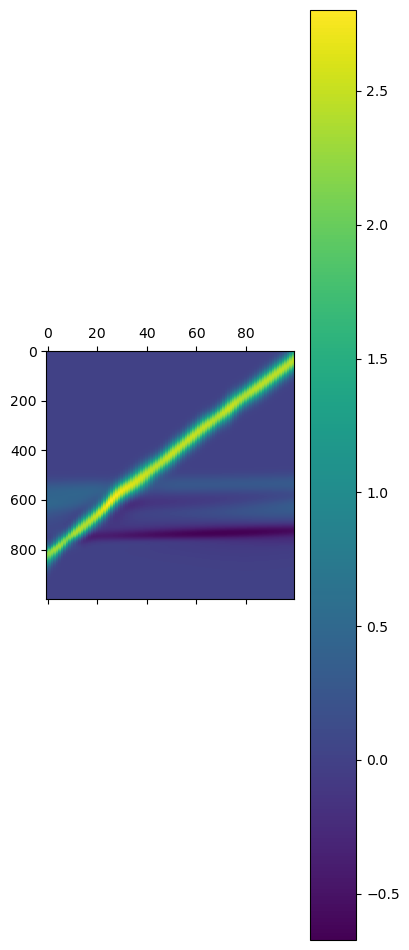

In [13]:
import numpy as np
import matplotlib.pyplot as plt


Q = torch.rand(number_of_times, number_of_samples)

for iter in range(number_of_times):
    theta_t = allTheta[:, iter]
    model_t = ShallowExp(d,m, theta_t)
    y_t = model_t(x_train)
    Q[iter, :] = y_t

Q = torch.fliplr(Q)

plt.matshow(Q.T.detach().numpy(), aspect=0.1)
plt.colorbar()
plt.show()
#plt.matshow(Q.detach().numpy(),  cmap ='Greens',
#              extent =[0, 4, 20,-10],
#              interpolation ='nearest',
#               origin ='lower')

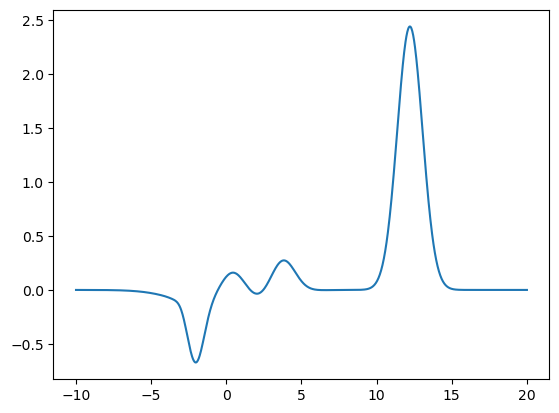

In [14]:
theta_t = allTheta[:, 70]
model_t = ShallowExp(d,m, theta_t)
y_t = model_t(x_train)

plt.plot(x_train.detach().numpy(), y_t.detach().numpy())

In [15]:
import torch as tc

def splitternn(x,m,d,l):
	c=x[:m]
	b=x[m:m+d*l].reshape(l,d)
	w=x[m+d*l:].reshape(l,m,d)
	return (c,b,w)

m,d,l=5,2,3
x=tc.rand(m+m*d*l+d*l)
print('x=',x,'size',x.shape)
c,b,w=splitternn(x,m,d,l)

print('size C',c.shape)
print(c)
print('size B',b.shape)
print(b[2])
print('size W',w.shape)
print(w[2])



x= tensor([0.0083, 0.3984, 0.5960, 0.5051, 0.8130, 0.5943, 0.5064, 0.2777, 0.9920,
        0.9155, 0.3695, 0.8002, 0.0965, 0.3496, 0.1895, 0.2498, 0.0909, 0.3586,
        0.4663, 0.6349, 0.5236, 0.1462, 0.2708, 0.6751, 0.2320, 0.5242, 0.9546,
        0.8931, 0.2501, 0.1346, 0.7316, 0.9508, 0.0842, 0.7354, 0.9832, 0.5185,
        0.0578, 0.9146, 0.8678, 0.1430, 0.9567]) size torch.Size([41])
size C torch.Size([5])
tensor([0.0083, 0.3984, 0.5960, 0.5051, 0.8130])
size B torch.Size([3, 2])
tensor([0.9155, 0.3695])
size W torch.Size([3, 5, 2])
tensor([[0.9508, 0.0842],
        [0.7354, 0.9832],
        [0.5185, 0.0578],
        [0.9146, 0.8678],
        [0.1430, 0.9567]])


In [35]:
x = torch.tensor(3)

tensor(3)
torch.Size([])


In [14]:
import torch as tc

m = 5
l = 3
d = 1
L = 0.5
x  = tc.tensor(3)
print(x)

c = tc.ones(m)
b = [tc.rand(d) for i in range(l)]
w = [tc.rand(m,d) for i in range(l)]

print(tc.tanh(w[0] * tc.sin(2*tc.pi*(x - b[0])/L)))
print()
print('pass')

x = tc.tanh(w[0]* tc.sin(2*tc.pi*(x - b[0])/L))
#print('x', x)
for k in range(1,l):
    x = tc.tanh(w[k] * x + b[k])
x = x.squeeze()
print(x)
x = tc.dot(c, x)

print('x', x)

tensor(3)
tensor([[-0.0034],
        [-0.0091],
        [-0.0909],
        [-0.0532],
        [-0.2283]])

pass
tensor([0.6689, 0.6245, 0.7229, 0.6439, 0.7311])
x tensor(3.3913)
